# LULC

In [1]:
# IMPORTS AND RANDOM SEEDS
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from patchify import unpatchify
from patchify import patchify

RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

In [2]:
# QoL Settings
debug = 0
optional_visuals = 0

In [3]:
patch_size = 128      # Size to split each training image into
patch_step = 32       # Amount to step when splitting up images for training (<size means some overlap)

percent_augment = 1   # Amount of the training data set to randomly augment (brightness, orientation)

epochs = 150          # Epochs of training for the CNN (early stopping is enabled)

## Data Import

In [4]:
full_image_path = "input/aerial_scaled.tif"  # Aerial raster of entire area to be classified
labels_aerial_path = "input/aerial_512.tif" # Aerial raster of just labelled data
labels_classes_path = "input/labels_raster_512.tif" # Class raster of labelled data

In [5]:
# Load Full Image Aerial
with rasterio.open(full_image_path) as src:
    full_image_raw = src.read()  # Read all bands
    full_image_meta = src.profile

# Load Classes Raster of Labelled Sample
with rasterio.open(labels_classes_path) as src:
    labels_classes_raw = src.read(1)  # Read the first (or only) band
    labels_classes_meta = src.profile

# Load Aerial Raster of Labelled Sample
with rasterio.open(labels_aerial_path) as src:
    labels_aerial_raw = src.read()
    labels_aerial_meta = src.profile

# Normalize images
full_image = full_image_raw.astype(np.float32) / 255.0  # Normalize to 0-1 range
labels_aerial = labels_aerial_raw.astype(np.float32) / 255.0 

# Print shapes
print("Full Image shape:", full_image.shape)  # Should be (Bands, Height, Width)
print("Labels Aerial shape:", labels_aerial.shape)
print("Labels Classes shape:", labels_classes_raw.shape)  # Should be (Height, Width)

Full Image shape: (3, 1280, 1536)
Labels Aerial shape: (3, 512, 512)
Labels Classes shape: (512, 512)


#### ***Optional:*** *Visualize full aerial and labelled data*

In [6]:
if optional_visuals:
    # Visualize full image
    rasterio.plot.show(full_image)

    # Visualize lablled aerial and classes
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(reshape_as_image(labels_aerial))
    ax[1].imshow(labels_classes_raw)

## Data Preparation
### Convert Class Labels to Categorical (One-Hot Encoded)

In [7]:
# SHIFT LABELS
# Classes are 1-indexed, need them 0-indexed                   # 0 building, 1 road, 2 vegetation, 3 alley/sidewalk/pavement
labels_classes_shifted = labels_classes_raw - 1

# ENCODE LABLES
num_classes = len(np.unique(labels_classes_shifted))
labels_classes = to_categorical(labels_classes_shifted, num_classes=num_classes)

print(f"Encoded {num_classes} classes") 

Encoded 4 classes


### Split Training and Testing Data

In [8]:
# TRAIN TEST SPLIT
split_x = int(labels_classes.shape[1] * 0.75) 

# Crop aerial and labels into train and test regions
labels_classes_train = labels_classes[:, :split_x]  
labels_classes_test = labels_classes[:, split_x:]  

labels_aerial_train = labels_aerial[:, :, :split_x]  
labels_aerial_test = labels_aerial[:, :, split_x:] 

print(f"labels_aerial_train: {labels_aerial_train.shape}, labels_classes_train: {labels_classes_train.shape}")
print(f"labels_aerial_test: {labels_aerial_test.shape},  labels_classes_test: {labels_classes_test.shape}")

labels_aerial_train: (3, 512, 384), labels_classes_train: (512, 384, 4)
labels_aerial_test: (3, 512, 128),  labels_classes_test: (512, 128, 4)


### Create Image Patches

In [9]:
# CREATE OVERLAPPING PATCHES
# Patchify separately for train and test to prevent data leakage
patches_classes_train = patchify(labels_classes_train, (patch_size, patch_size, num_classes), step=patch_step)
patches_classes_test = patchify(labels_classes_test, (patch_size, patch_size, num_classes), step=patch_step)

patches_aerial_train = patchify(labels_aerial_train, (3, patch_size, patch_size), step=patch_step)[0]
patches_aerial_test = patchify(labels_aerial_test, (3, patch_size, patch_size), step=patch_step)[0]

# Reshape patches into lists
X_train_orig = patches_aerial_train.reshape(-1, 3, patch_size, patch_size)
X_train_orig = np.transpose(X_train_orig, (0, 2, 3, 1))

Y_train_orig = patches_classes_train.reshape(-1, patch_size, patch_size, num_classes)

X_test = patches_aerial_test.reshape(-1, 3, patch_size, patch_size)
X_test = np.transpose(X_test, (0, 2, 3, 1))

Y_test = patches_classes_test.reshape(-1, patch_size, patch_size, num_classes)

print(f"New Train set - X: {X_train_orig.shape}, Y: {Y_train_orig.shape}")
print(f"New Test set -  X: {X_test.shape},  Y: {Y_test.shape}")

New Train set - X: (117, 128, 128, 3), Y: (117, 128, 128, 4)
New Test set -  X: (13, 128, 128, 3),  Y: (13, 128, 128, 4)


#### ***Optional:*** *Visualize patches*

In [10]:
patches_to_show = 4 # How many patches to show (<20 recommended)

if optional_visuals:    
    shown = 0
    num_patches = X_train.shape[0]

    # Visulaize aerial raster and class raster patches next to each other
    while shown < min(patches_to_show, num_patches):    
        fig, ax = plt.subplots(1, 2, figsize=(10,10))
        ax[0].imshow(X_train[shown])
        ax[1].imshow(Y_train[shown])

        shown += 1

### Data Augmentation

In [11]:
def augment(image, label, brightness_factor=0.2, flip_prob=0.5, rotate_prob=0.5, noise_prob=0.5, zoom_prob=0.2):
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=brightness_factor)

    # Random contrast
    image  = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Random hue
    image = tf.image.random_hue(image, max_delta=0.05)
    
    # Random horizontal flipping
    if tf.random.uniform([]) < flip_prob:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    # Random rotation (90, 180, 270)
    if tf.random.uniform([]) < rotate_prob:
        k = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        label = tf.image.rot90(label, k=k)

    # Gaussian noise
    if tf.random.uniform([]) < noise_prob:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # Random zoon
    if tf.random.uniform([]) < zoom_prob:
        crop_factor = tf.random.uniform([], minval=0.7, maxval=1.0)
        h, w, _ = image.shape
        new_h = tf.cast(h * crop_factor, tf.int32)
        new_w = tf.cast(w * crop_factor, tf.int32)

        image = tf.image.resize_with_crop_or_pad(image, new_h, new_w)
        label = tf.image.resize_with_crop_or_pad(label, new_h, new_w)

        image = tf.image.resize(image, [h,w])
        label = tf.image.resize(label, [h,w])

    return image, label

Added 117 augmented images. New training total: 234


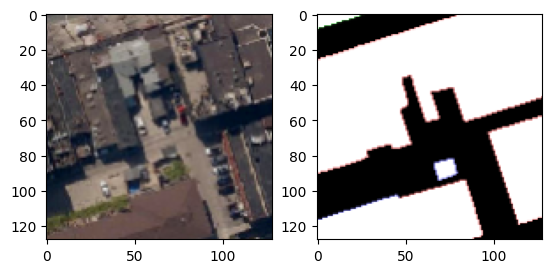

In [12]:
# Randomly select indices for augmentation
num_aug_samples = int(percent_augment * X_train_orig.shape[0])
augment_indices = np.random.choice(X_train_orig.shape[0], num_aug_samples, replace=False)

# Apply augmentation
X_aug = []
Y_aug = []

for idx in augment_indices:
    new_image, new_label = augment(X_train_orig[idx], Y_train_orig[idx])
    X_aug.append(np.array(new_image))  
    Y_aug.append(np.array(new_label))
    
# Convert to NumPy and concatenate with original dataset
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

X_train = np.concatenate([X_train_orig, X_aug], axis=0)
Y_train = np.concatenate([Y_train_orig, Y_aug], axis=0)

fig, ax = plt.subplots(1,2)
ax[0].imshow(X_train[-1])
ax[1].imshow(Y_train[-1])

print(f"Added {num_aug_samples} augmented images. New training total: {X_train.shape[0]}")

## Build CNN Model


In [13]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),  # Upsample back

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(4, (1,1), activation='softmax')  # Output 4 classes per pixel
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

C:\Users\Connor\Documents\Code\QGIS\to-lulc-aiml\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 4)         │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,365,924 (5.21 MB)

 Trainable params: 1,365,924 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the Model

In [14]:
# Enable early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test),
                    epochs=epochs, batch_size=32, 
                    callbacks=[early_stopping],
                   )

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.4346 - loss: 1.3536 - val_accuracy: 0.3263 - val_loss: 1.2871
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.4490 - loss: 1.2279 - val_accuracy: 0.5619 - val_loss: 1.0914
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.5301 - loss: 1.1173 - val_accuracy: 0.5619 - val_loss: 1.1047
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.5301 - loss: 1.1118 - val_accuracy: 0.5619 - val_loss: 1.0832
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.5301 - loss: 1.0999 - val_accuracy: 0.5619 - val_loss: 1.0660
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.5301 - loss: 1.0903 - val_accuracy: 0.5619 - val_loss: 1.0589
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.5301 - loss: 1.0808 - val_accuracy: 0.5619 - val_loss: 1.0654
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.5301 - loss: 1.0721 - val_accuracy: 0.5619 - v

### Evaluate Accuracy

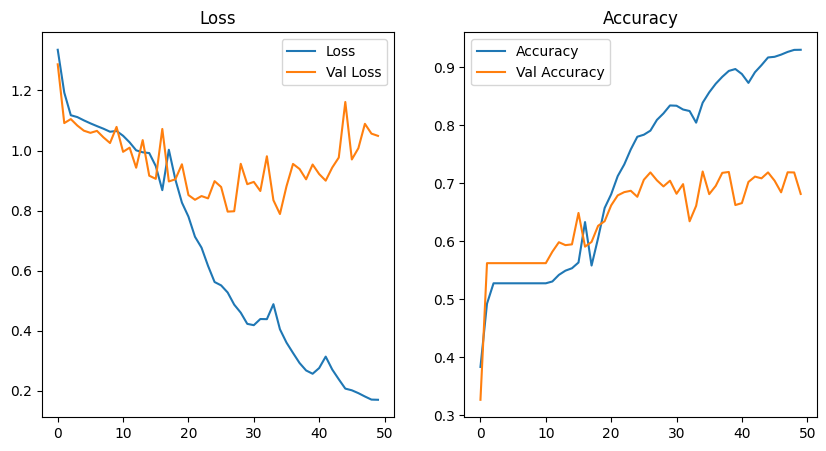

In [15]:
# Plot training loss & accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.show()

## Predict the Image

### Full Image Preprocessing

In [16]:
full_image_reshaped = reshape_as_image(full_image)
print("Full Image shape:", full_image_reshaped.shape)  

# Turn full image into patches to be predicted (same size and step as before)
patches_full = patchify(full_image_reshaped, (patch_size, patch_size, 3), step=patch_step)
patches_full_x, patches_full_y = patches_full.shape[0:2]

# Turn 2D array of patches into one list of patches i.e. (num_patches, patch_size, patch_size, bands)
patches_full_reshaped = patches_full.reshape(-1, patch_size, patch_size, 3)
print("Reshaped for Model shape:", patches_full_reshaped.shape)  

Full Image shape: (1280, 1536, 3)
Reshaped for Model shape: (1665, 128, 128, 3)


### Full Image Prediction

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step
Predictions shape: (1665, 128, 128, 4)


C:\Users\Connor\AppData\Local\Temp\ipykernel_20096\2953408948.py:27: RuntimeWarning: invalid value encountered in divide
  full_prediction /= weight_matrix
C:\Users\Connor\AppData\Local\Temp\ipykernel_20096\2953408948.py:28: RuntimeWarning: invalid value encountered in cast
  full_prediction = full_prediction.astype(np.uint8)


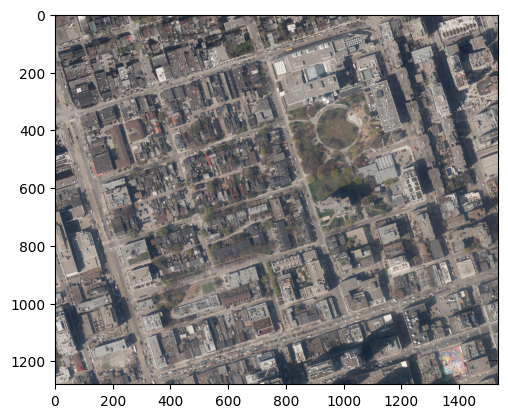

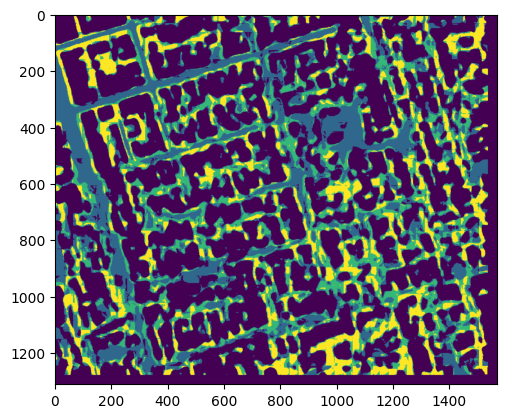

Training size: (512, 512)
Prediction size: (1312, 1568)
Patch size: 128
Patch step: 32
Augmented: 100%


In [17]:
# Predict the full image
predictions = model.predict(patches_full_reshaped)
print("Predictions shape:", predictions.shape) 

predictions = predictions.reshape(patches_full.shape[0], patches_full.shape[1], patch_size, patch_size, -1)

predicted_classes = np.argmax(predictions, axis=-1)

## BLENDING MATRIX IMPLEMENTATION
# Initialize accumulation and weight matrices
full_prediction = np.zeros((patches_full_x * patch_step + patch_size, 
                            patches_full_y * patch_step + patch_size), dtype=np.float32)
weight_matrix = np.zeros_like(full_prediction, dtype=np.float32)

# Blend patches
for i in range(patches_full_x):
    for j in range(patches_full_y):
        x_start = i * patch_step
        x_end = x_start + patch_size
        y_start = j * patch_step
        y_end = y_start + patch_size
        
        full_prediction[x_start:x_end, y_start:y_end] += predicted_classes[i, j]
        weight_matrix[x_start:x_end, y_start:y_end] += 1  # Track contributions

# Normalize by the number of times each pixel was predicted
full_prediction /= weight_matrix
full_prediction = full_prediction.astype(np.uint8)

rasterio.plot.show(full_image)
rasterio.plot.show(full_prediction)

print(f"Training size: {labels_classes_raw.shape}\nPrediction size: {full_prediction.shape}\nPatch size: {patch_size}\nPatch step: {patch_step}\nAugmented: {percent_augment*100}%")